<a href="https://colab.research.google.com/github/aemrhb/IPI_project-seminar/blob/main/faster_Rcnnn_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd gdrive/My Drive/faster-Rccn-finetune

/content/gdrive/My Drive/faster-Rccn-finetune


In [3]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

fatal: destination path 'vision' already exists and is not an empty directory.
fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [4]:
import torchvision

In [5]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
# from torchvision.datasets import YourCustomDataset
from torch.optim import SGD
import torch.utils.data
import torchvision.transforms as T

In [6]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
# from engine import train_one_epoch, evaluate
# import utils
# import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [7]:
import cv2
import os
from PIL import Image
import numpy as np
import torch
# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw

In [8]:
files_dir = '/content/gdrive/My Drive/faster-Rccn-finetune/data/Kuken_videos-00_0'

In [9]:
imge_path = os.path.join(files_dir, "img1" )
annots_path  = os.path.join(files_dir ,"annot")

In [69]:
# # from torchvision.ops import boxes
# imgs = list(sorted(os.listdir(imge_path)))

# annot_path = os.path.join(files_dir, imgs[1])
# # annot = list(sorted(os.listdir(files_dir)))
# # print(imgs[1][:-4])
# # img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
# img_path = os.path.join(imge_path, imgs[1])
# print(img_path)
# img = cv2.imread(img_path)
# img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
# print(imgs[70])
# print(imgs[70][:-4] + '.txt')
# annot_file = imgs[1][:-4] + '.txt'
# annot_path = os.path.join(annots_path,annot_file)
# print(annot_path)
# with open(annot_path, "r") as file:
#   file_contents = file.read()
# lines = file_contents.split("\n")
# data = np.matrix(lines)
# boxes = []
# labels = []
# area = []

# for i in range(data.shape[1] - 1 ):
#   boxe = []
#   line = data[0,i].split(",")
#   # print(line)
#   strr = line[2:6]
#   res = [float(t) for t in strr]

#   are = int((res[2] - res[0]) * (res[3] - res[1]))
#   area.append(are)
#   boxes.append(res)
#   labels.append(float(line[7]))


# boxes = torch.as_tensor(boxes, dtype=torch.float32)
# labels = torch.as_tensor(labels, dtype=torch.int64)
# area = torch.as_tensor(area, dtype=torch.int64)
# iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
# image_id = torch.tensor([2])


# target = {}


# target["boxes"] = boxes
# target["labels"] = labels
# target["area"] = area
# target["iscrowd"] = iscrowd
# target["image_id"] = image_id
# # image_id
# image_id = torch.tensor([2])
# # print(boxes)
# # print(labels)
# # print(area)
# # print(iscrowd)
# # print(target)
# # print(type(target))



/content/gdrive/My Drive/faster-Rccn-finetune/data/Kuken_videos-00_0/img1/000002.jpg
000071.jpg
000071.txt
/content/gdrive/My Drive/faster-Rccn-finetune/data/Kuken_videos-00_0/annot/000002.txt


In [70]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, files_dir,width, height, transforms=None):  # Add necessary arguments for dataset initialization
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width

        self.imgs = list(sorted(os.listdir(imge_path)))
                        

        
        
    
    def __getitem__(self, idx):
        # Implement dataset item retrieval logic
        imge_path = os.path.join(self.files_dir , "img1" )
        img_name = self.imgs[idx]
        img_path = os.path.join(imge_path, img_name)
        img = cv2.imread(img_path)
        wt = img.shape[1]
        ht = img.shape[0]
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)

        img_res /= 255.0

        
        annots_path  = os.path.join(files_dir ,"annot")
        annot_file = img_name[:-4] + '.txt'
        annot_path = os.path.join(annots_path,annot_file)
        with open(annot_path, "r") as file:
          file_contents = file.read()
        lines = file_contents.split("\n")
        data = np.matrix(lines)
        boxes = []
        labels = []
        area = []

        for i in range(data.shape[1] - 1 ):
          boxe = []
          line = data[0,i].split(",")
          # print(line)
          strr = line[2:6]

          res = [float(t) for t in strr]
            
          xmin_corr = (res[0]/wt)*self.width
          xmax_corr = (res[2]/wt)*self.width
          ymin_corr = (res[1]/ht)*self.height
          ymax_corr = (res[3]/ht)*self.height

          are = int((res[2] - res[0]) * (res[3] - res[1]))
          area.append(are)
          boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
          labels.append(float(line[7]))


        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        area = torch.as_tensor(area, dtype=torch.int64)
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        image_id = torch.tensor([idx])


        target = {}

        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["image_id"] = image_id

        if self.transforms:
            
            sample = self.transforms(image = img_res)
                                    #  bboxes = target['boxes'],
                                    #  labels = labels)
            
            img_res = sample['image']
            # target['boxes'] = torch.Tensor(sample['bboxes'])

        return img_res, target

    
    def __len__(self):
        # Return the size of the dataset
        return len(self.imgs)
       

In [33]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [57]:
# def get_transform(train):
    
#     if train:
#         return A.Compose([
#                             A.HorizontalFlip(0.5),
#                      # ToTensorV2 converts image to pytorch tensor without div by 255
#                             ToTensorV2(p=1.0) 
#                         ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
#     else:
#         return A.Compose([
#                             ToTensorV2(p=1.0)
#                         ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [59]:
def get_transform(train):
    if train:
        return A.Compose([
            ToTensorV2(p=1.0)
        ])
    else:
        return A.Compose([
            ToTensorV2(p=1.0)
        ])

In [71]:
dataset = CustomDataset(files_dir, 480, 480, transforms= get_transform(train=True))
# dataset[0]
# print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[87]
# for key, value in target.items():
#     print(key, value)
print(img.shape, '\n',target)

torch.Size([3, 480, 480]) 
 {'boxes': tensor([[198.8250, 191.6667,  77.7450,  85.8733],
        [ 28.0575,  82.5133,  17.3213,  22.8600],
        [ 91.0687, 256.4733,  15.7425,  38.9067],
        [100.4212, 271.3067,  21.7275,  26.9267],
        [105.2175, 236.7800,  27.8025,  27.2000],
        [ 27.3150, 194.4200,  22.5150,  34.0600],
        [263.0100, 279.2267,  20.5575,  30.8200],
        [293.1412, 280.1400,  24.6600,  34.9133],
        [329.4713, 276.1800,  19.2638,  34.8667],
        [344.2087, 272.8067,  17.7150,  29.1333],
        [262.6950, 149.9733,  15.0600,  44.2267],
        [268.7850, 143.5867,  26.5275,  24.2000],
        [269.4788, 118.0800,  25.2638,  29.9333],
        [263.3775,  86.0667,  13.9237,  42.1600],
        [272.5763,  93.0800,  16.2300,  37.8467],
        [ 26.5425,  90.8800,  13.3275,  32.0400]]), 'labels': tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'area': tensor([ 51237,   2561,  65553,  76924,  64898,   3078, 240907, 263355, 299428,
    

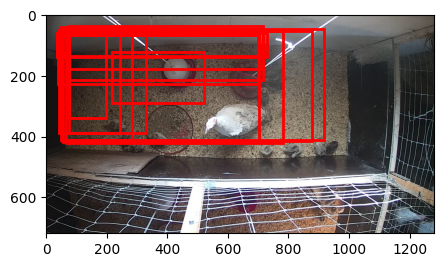

In [ ]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
  

    
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[60]
plot_img_bbox(img, target)

In [62]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model
    

In [63]:
def custom_coll(data) :
  return data

In [72]:
# dataset = CustomDataset(files_dir)
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=custom_coll)


In [65]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2
model = get_object_detection_model(num_classes)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [49]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [18]:
# !pip install pyttsx3
# import pyttsx3
# engine = pyttsx3.init()
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [1]:
num_epochs = 10

# for epoch in range(num_epochs):
imge = []
targettsf =[]
for data in dataset :
  # print(data[1])
  imge.append(data[0].to(device))
  targ = {}
  targ["boxes"] = data[1]["boxes"].to(device)
  targ["labels"]= data[1]["labels"].to(device)
  targ["area"]= data[1]["area"].to(device)
  targ["iscrowd"]= data[1]["iscrowd"].to(device)
  targ["image_id"]= data[1]["image_id"].to(device)
  targettsf.append(targ)



loss_dic = model(imge,targettsf)
  


  # for d in data :
  #  imge.append(d[0])
print(len(imge))

NameError: ignored